## Stock price prediction using LSTM and SVR with Feature engineering and Hyperparameter Tuning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download historical stock data
ticker = "GOOGL"
start_date = "2018-01-01"
end_date = "2023-10-31"

df = yf.download(ticker, start=start_date, end=end_date, progress=False)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000
...,...,...,...,...,...,...
2023-10-24,137.830002,139.360001,137.419998,138.809998,138.809998,44814300
2023-10-25,128.160004,128.309998,125.070000,125.610001,125.610001,84366200
2023-10-26,123.269997,124.330002,121.269997,122.279999,122.279999,57061100


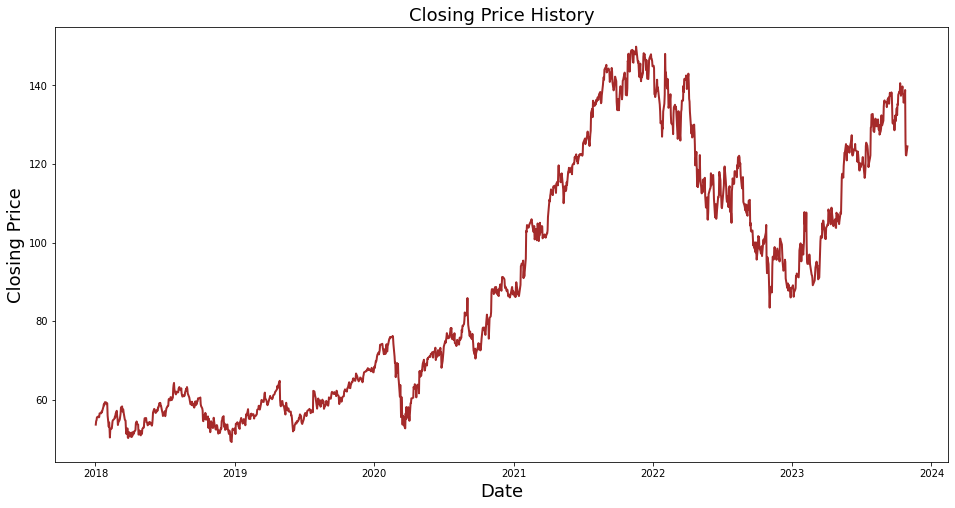

In [3]:
# Plot the closing price history
plt.figure(figsize=(16,8))
plt.title('Closing Price History', fontsize=18)
plt.plot(df['Close'], linewidth=2, color='brown')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.show()

In [4]:
# Feature Engineering
df['Return'] = df['Close'].pct_change() # Simple daily return
df['Moving_Avg_5'] = df['Close'].rolling(window=5).mean() # 5-day moving average
df['Moving_Avg_10'] = df['Close'].rolling(window=10).mean() # 10-day moving average
df['Moving_STD_10'] = df['Close'].rolling(window=10).std() # 10-day moving standard deviation

# Replace NA values with 0
df.fillna(0, inplace=True)

df.head(30)

,Open,High,Low,Close,Adj Close,Volume,Return,Moving_Avg_5,Moving_Avg_10,Moving_STD_10
Date,,,,,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000,0.000000,0.000000,0.000000,0.000000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000,0.017061,0.000000,0.000000,0.000000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000,0.003884,0.000000,0.000000,0.000000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000,0.013260,0.000000,0.000000,0.000000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000,0.003531,54.849899,0.000000,0.000000
2018-01-09,55.922001,55.922001,55.410000,55.639500,55.639500,26808000,-0.001274,55.245699,0.000000,0.000000
2018-01-10,55.349998,55.639000,55.199001,55.507000,55.507000,20734000,-0.002381,55.431899,0.000000,0.000000
2018-01-11,55.615501,55.742500,55.324001,55.602501,55.602501,22424000,0.001721,55.594800,0.000000,0.000000
2018-01-12,55.505001,56.564999,55.400501,56.532501,56.532501,38586000,0.016726,55.798400,0.000000,0.000000


In [5]:
# Removing first 9 rows since they contain 0 values
df1 = df[9:]

df1.head()

,Open,High,Low,Close,Adj Close,Volume,Return,Moving_Avg_5,Moving_Avg_10,Moving_STD_10
Date,,,,,,,,,,
2018-01-16,57.015499,57.444000,56.3330,56.535000,56.535000,36462000,0.000044,55.963300,55.40660,0.873630
2018-01-17,56.818001,56.966000,56.1745,56.955002,56.955002,27830000,0.007429,56.226401,55.73605,0.755158
2018-01-18,56.967499,57.029499,56.2230,56.798500,56.798500,27498000,-0.002748,56.484701,55.95830,0.700913
2018-01-19,56.901501,57.188999,56.6250,57.174999,57.174999,30552000,0.006629,56.799200,56.19700,0.663533
2018-01-22,57.191002,58.344002,57.0910,58.208000,58.208000,29550000,0.018067,57.134300,56.46635,0.870204


In [6]:
df1.dropna(inplace=True)
df1.head()

,Open,High,Low,Close,Adj Close,Volume,Return,Moving_Avg_5,Moving_Avg_10,Moving_STD_10
Date,,,,,,,,,,
2018-01-16,57.015499,57.444000,56.3330,56.535000,56.535000,36462000,0.000044,55.963300,55.40660,0.873630
2018-01-17,56.818001,56.966000,56.1745,56.955002,56.955002,27830000,0.007429,56.226401,55.73605,0.755158
2018-01-18,56.967499,57.029499,56.2230,56.798500,56.798500,27498000,-0.002748,56.484701,55.95830,0.700913
2018-01-19,56.901501,57.188999,56.6250,57.174999,57.174999,30552000,0.006629,56.799200,56.19700,0.663533
2018-01-22,57.191002,58.344002,57.0910,58.208000,58.208000,29550000,0.018067,57.134300,56.46635,0.870204


In [7]:
# Define the features and the target variable
features = ['Open', 'High', 'Low', 'Return', 'Moving_Avg_5', 'Moving_Avg_10', 'Moving_STD_10']

X = df1[features]
y = df1['Close']

# Feature Scaling
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X)

target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y.values.reshape(-1,1))

In [8]:
# Split the data into training and testing sets using 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False, random_state=42)

In [9]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (1166, 7)
y_train shape:  (1166, 1)
X_test shape:  (292, 7)
y_test shape:  (292, 1)


In [10]:
# Since LSTM expects a 3D array as input, we need to reshape the data
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [11]:
print("X_train_lstm shape: ", X_train_lstm.shape)
print("X_test_lstm shape: ", X_test_lstm.shape)

X_train_lstm shape:  (1166, 1, 7)
X_test_lstm shape:  (292, 1, 7)


In [12]:
# Create a Estimator class for LSTM model
class LSTMEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, optimizer='adam'):
        self.optimizer = optimizer
        self.model = Sequential()
        self.model.add(LSTM(100, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(1))
        self.model.compile(optimizer=self.optimizer, loss='mse')

    def fit(self, X, y):
        self.model.fit(X, y, epochs=100, batch_size=64, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()
    
# Create the LSTM model
lstm_model = LSTMEstimator()
lstm_model.fit(X_train_lstm, y_train)

LSTMEstimator()

In [13]:
# Build SVR model
svr_model = SVR()
svr_model.fit(X_train, y_train)

SVR()

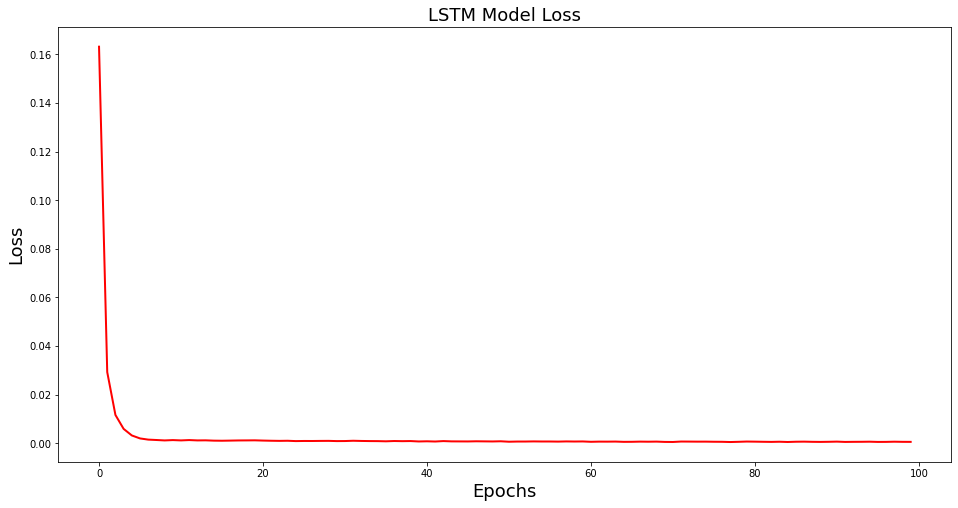

In [14]:
# Plot the training and validation loss for the LSTM model
plt.figure(figsize=(16,8))
plt.plot(lstm_model.model.history.history['loss'], linewidth=2, color='red')
plt.title('LSTM Model Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

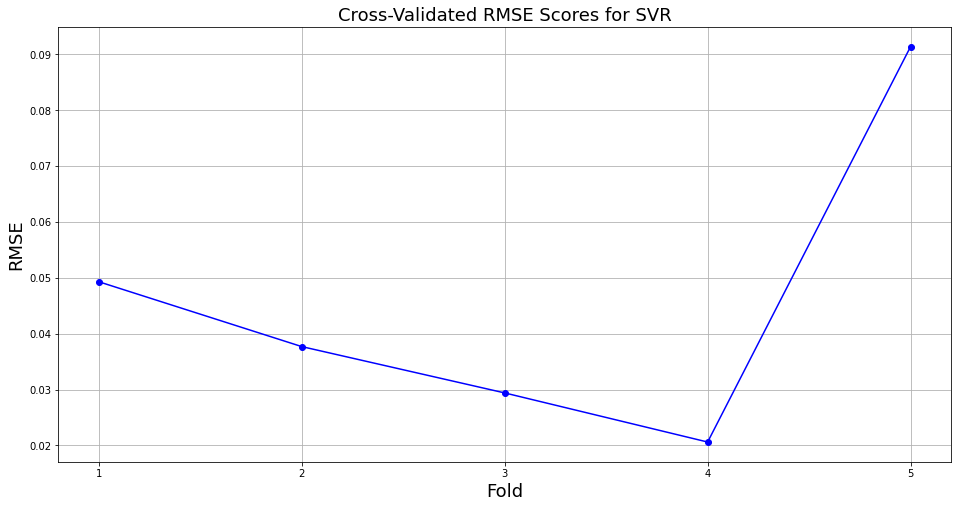

In [15]:
# Plot the training and validation loss for the SVR model
from sklearn.model_selection import cross_val_score

svr_scores = cross_val_score(svr_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
svr_rmse_scores = np.sqrt(-svr_scores)

plt.figure(figsize=(16,8))
plt.plot(range(1, 6), svr_rmse_scores, marker='o', linestyle='-', color='blue')
plt.title('Cross-Validated RMSE Scores for SVR', fontsize=18)
plt.xlabel('Fold', fontsize=18)
plt.ylabel('RMSE', fontsize=18)
plt.xticks(range(1, 6))
plt.grid(True)
plt.show()

In [16]:
# Make predictions using LSTM and SVR models
pred_lstm = lstm_model.predict(X_test_lstm)
pred_svr = svr_model.predict(X_test)

10/10 [==============================] - 0s 1ms/step


In [17]:
# Inverse transform the predicted values
pred_lstm_inv = target_scaler.inverse_transform(pred_lstm.reshape(-1,1))
pred_svr_inv = target_scaler.inverse_transform(pred_svr.reshape(-1,1))
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1,1))

In [18]:
# Create a stacked model
stacked_pred = np.column_stack((pred_lstm, pred_svr))

# Train final regressor based on stacked predictions
final_regressor = LinearRegression().fit(stacked_pred, y_test)

final_pred = final_regressor.predict(stacked_pred)

final_pred_inv = target_scaler.inverse_transform(final_pred.reshape(-1, 1))

In [19]:
# Calculate the Evaluatioon metrics for LSTM model without hyperparameter tuning
lstm_mse = mean_squared_error(y_test_inv, pred_lstm_inv)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test_inv, pred_lstm_inv)
lstm_r2 = r2_score(y_test_inv, pred_lstm_inv)

print("LSTM Model Evaluation Metrics")
print("=============================")
print("MSE: {:.4f}".format(lstm_mse))
print("RMSE: {:.4f}".format(lstm_rmse))
print("MAE: {:.4f}".format(lstm_mae))
print("R2 Score: {:.4f}".format(lstm_r2))

LSTM Model Evaluation Metrics
MSE: 0.9089
RMSE: 0.9534
MAE: 0.7638
R2 Score: 0.9965


In [20]:
# Calculate the Evaluation Metrics for SVR model without Hyperparameter Tuning
svr_mse = mean_squared_error(y_test_inv, pred_svr_inv)
svr_rmse = np.sqrt(svr_mse)
svr_mae = mean_absolute_error(y_test_inv, pred_svr_inv)
svr_r2 = r2_score(y_test_inv, pred_svr_inv)

print("SVR Model Evaluation Metrics")
print("=============================")
print("MSE: {:.4f}".format(svr_mse))
print("RMSE: {:.4f}".format(svr_rmse))
print("MAE: {:.4f}".format(svr_mae))
print("R2 Score: {:.4f}".format(svr_r2))

SVR Model Evaluation Metrics
MSE: 4.5108
RMSE: 2.1239
MAE: 1.7096
R2 Score: 0.9827


In [21]:
# Calculate the Evaluation Metrics for Stacked Model
stacked_mse = mean_squared_error(y_test_inv, final_pred_inv)
stacked_rmse = np.sqrt(stacked_mse)
stacked_mae = mean_absolute_error(y_test_inv, final_pred_inv)
stacked_r2 = r2_score(y_test_inv, final_pred_inv)

print("LSTM-SVR Stacked Model Evaluation Metrics")
print("=========================================")
print("MSE: {:.4f}".format(stacked_mse))
print("RMSE: {:.4f}".format(stacked_rmse))
print("MAE: {:.4f}".format(stacked_mae))
print("R2 Score: {:.4f}".format(stacked_r2))

LSTM-SVR Stacked Model Evaluation Metrics
MSE: 0.7988
RMSE: 0.8938
MAE: 0.7078
R2 Score: 0.9969


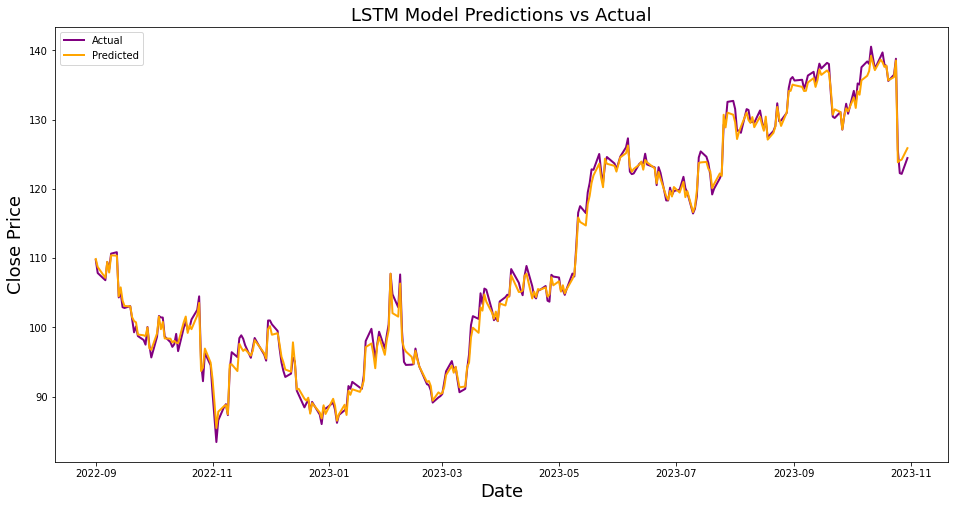

In [22]:
# Plot the predictions of LSTM model
plt.figure(figsize=(16,8))
plt.title('LSTM Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='purple', label='Actual')
plt.plot(df1.index[-len(y_test):], pred_lstm_inv, linewidth=2, color='orange', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(loc='best')
plt.show()

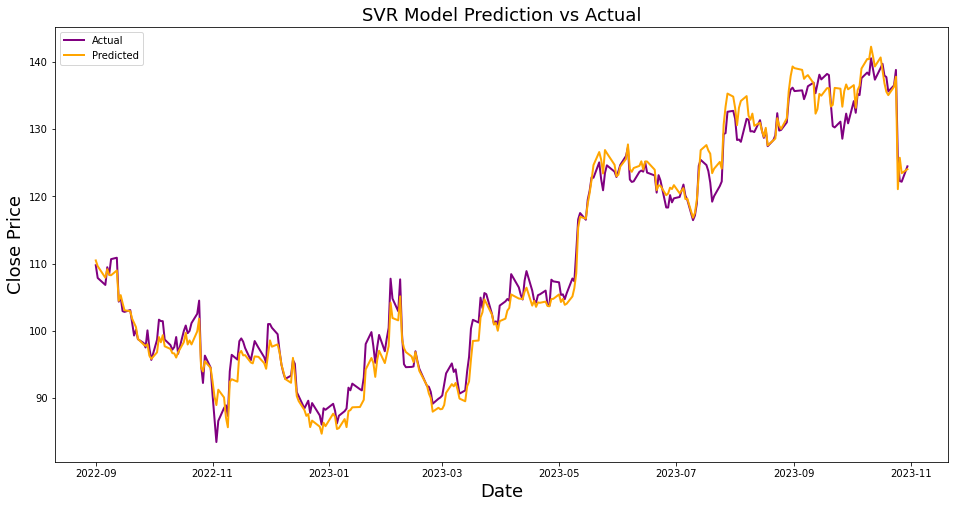

In [23]:
# Plot the predictions for SVR model
plt.figure(figsize=(16,8))
plt.title('SVR Model Prediction vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='purple', label='Actual')
plt.plot(df1.index[-len(y_test):], pred_svr_inv, linewidth=2, color='orange', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(loc='best')
plt.show()

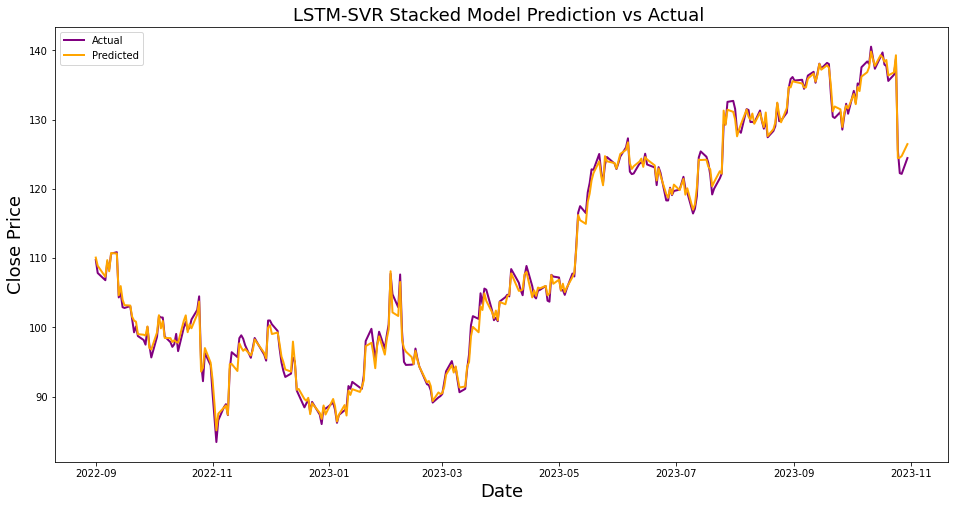

In [24]:
# Plot the predictions for Stacked model
plt.figure(figsize=(16,8))
plt.title('LSTM-SVR Stacked Model Prediction vs Actual ', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='purple', label='Actual')
plt.plot(df1.index[-len(y_test):], final_pred_inv, linewidth=2, color='orange', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(loc='best')
plt.show()

In [25]:
# Build a dataframe with actual and predicted prices
df_pred = pd.DataFrame({'Date': df1.index[-len(y_test):],'Actual': y_test_inv.flatten(), 'LSTM': pred_lstm_inv.flatten(), 'SVR': pred_svr_inv.flatten(), 'Stacked': final_pred_inv.flatten()})
df_pred.head(20)

,Date,Actual,LSTM,SVR,Stacked
0,2022-09-01,109.739998,109.870659,110.458194,110.079774
1,2022-09-02,107.849998,108.722198,109.598923,108.899177
2,2022-09-06,106.809998,107.149292,107.886773,107.305076
3,2022-09-07,109.449997,109.467949,109.148575,109.708756
4,2022-09-08,108.379997,107.919838,108.290732,108.104533
5,2022-09-09,110.650002,110.405106,108.250477,110.740274
6,2022-09-12,110.860001,110.359993,108.963163,110.662095
7,2022-09-13,104.320000,104.484177,104.443615,104.627149
8,2022-09-14,105.000000,105.781441,105.293996,105.965829
9,2022-09-15,102.910004,103.868660,104.118818,103.988626


In [26]:
# Take the last day of data for predictions
last_features = X_scaled[-1:]

predicted_prices_lstm = []

# Predicting stock prices for the next 2 days
for _ in range(2):
    # Prepare the last features for LSTM input shape
    last_features_lstm = last_features.reshape(1, 1, X_train_lstm.shape[2])
    
    # Predicting the next day stock price using the last feature data
    predicted_price = lstm_model.predict(last_features_lstm)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped = predicted_price.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price = target_scaler.inverse_transform(predicted_price_reshaped)[0][0]
    predicted_prices_lstm.append(inverse_transformed_price)

    # Computing new features based on the predicted price
    new_features = np.array([
        last_features[0, 1],  # 'Open' value for the next day (shifted from 'High' of the current day)
        last_features[0, 2],  # 'High' value for the next day (shifted from 'Low' of the current day)
        predicted_price_reshaped[0, 0], # 'Low' value (using the predicted closing price as an approximation)
        (predicted_price_reshaped[0, 0] - last_features[0, 3]) / last_features[0, 3],  # Return for the predicted day
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped[0, 0])),  # 5-day moving average
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped[0, 0])),  # 10-day moving average
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped[0, 0]))    # 10-day moving standard deviation
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features

print("Predicted Closing Prices for the Next 2 Days (LSTM Model):")
for i, price in enumerate(predicted_prices_lstm):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 35ms/step
Predicted Closing Prices for the Next 2 Days (LSTM Model):
Day 1:125.887
Day 2:122.365


In [27]:
last_features = X_scaled[-1:]

# Predict using the svr model
predicted_prices_svr = []

last_features_svr = last_features.copy()

for _ in range(2):
    # Predicting the next day stock price using the last feature data
    predicted_price_svr = svr_model.predict(last_features_svr)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_svr = predicted_price_svr.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price_svr = target_scaler.inverse_transform(predicted_price_reshaped_svr)[0][0]
    predicted_prices_svr.append(inverse_transformed_price_svr)

    # Computing new features based on the predicted price
    # Here we reuse the logic for LSTM for simplicity. Depending on the scenario, the exact methodology might change.
    new_features_svr = np.array([
        last_features_svr[0, 1], 
        last_features_svr[0, 2], 
        predicted_price_reshaped_svr[0, 0], 
        (predicted_price_reshaped_svr[0, 0] - last_features_svr[0, 3]) / last_features_svr[0, 3],
        np.mean(np.append(last_features_svr[0, 4:6], predicted_price_reshaped_svr[0, 0])),
        np.mean(np.append(last_features_svr[0, 5:], predicted_price_reshaped_svr[0, 0])),
        np.std(np.append(last_features_svr[0, 6:], predicted_price_reshaped_svr[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features_svr = new_features_svr

print("\nPredicted Closing Prices for the Next 2 Days (SVR Model):")
for i, price in enumerate(predicted_prices_svr):
    print(f"Day {i+1}:" "{:.3f}".format(price))


Predicted Closing Prices for the Next 2 Days (SVR Model):
Day 1:124.038
Day 2:118.282


In [28]:
last_features = X_scaled[-1:]

# Predict using the stacked model
predicted_prices_stacked = []

last_features_stacked = last_features.copy()

for _ in range(2):
    # Reshape the last features for LSTM input shape
    last_features_lstm = last_features.reshape(1, 1, X_train_lstm.shape[2])

    # Predict using the LSTM model & SVR model
    lstm_pred_for_stacking = lstm_model.predict(last_features_lstm).flatten()
    svr_pred_for_stacking = svr_model.predict(last_features_stacked).flatten()

    # Stack the predictions together
    stacked_pred = np.column_stack((lstm_pred_for_stacking, svr_pred_for_stacking))

    # Predict using the final regressor
    predicted_stacked = final_regressor.predict(stacked_pred)

    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_stacked = predicted_stacked.reshape(-1, 1)

    # Saving the predicted price after inverse transformation
    inverse_transformed_price_stacked = target_scaler.inverse_transform(predicted_price_reshaped_stacked)[0][0]
    predicted_prices_stacked.append(inverse_transformed_price_stacked)

    # Computing new features based on the predicted price
    # Here we reuse the logic for LSTM for simplicity. Depending on the scenario, the exact methodology might change.
    new_features_stacked = np.array([
        last_features_stacked[0, 1], 
        last_features_stacked[0, 2], 
        predicted_price_reshaped_stacked[0, 0], 
        (predicted_price_reshaped_stacked[0, 0] - last_features_stacked[0, 3]) / last_features_stacked[0, 3],
        np.mean(np.append(last_features_stacked[0, 4:6], predicted_price_reshaped_stacked[0, 0])),
        np.mean(np.append(last_features_stacked[0, 5:], predicted_price_reshaped_stacked[0, 0])),
        np.std(np.append(last_features_stacked[0, 6:], predicted_price_reshaped_stacked[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features_stacked = new_features_stacked

print("\nPredicted Closing Prices for the Next 2 Days (Stacked Model):")
for i, price in enumerate(predicted_prices_stacked):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step

Predicted Closing Prices for the Next 2 Days (Stacked Model):
Day 1:126.476
Day 2:126.657


In [29]:
# LSTM model with hyperparameter tuning
# Define the parameter grid
param_grid = {'optimizer': ['Adam','RMSprop','SGD']}

# Grid search on LSTM
grid = GridSearchCV(estimator=LSTMEstimator(), param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_lstm = grid.fit(X_train_lstm, y_train)

# Print the best parameters
print("Best parameters: ", grid_lstm.best_params_)
print("Best score: ", grid_lstm.best_score_)
print("Best estimator: ", grid_lstm.best_estimator_)

# Using the best estimator for LSTM from the grid search
best_lstm_model = grid_lstm.best_estimator_

# Predicting the test data
pred_best_lstm = best_lstm_model.predict(X_test_lstm)

# Inverse transform the predictions
pred_best_lstm_inv = target_scaler.inverse_transform(pred_best_lstm.reshape(-1,1))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters:  {'optimizer': 'Adam'}
Best score:  0.9882741498454278
Best estimator:  LSTMEstimator(optimizer='Adam')
10/10 [==============================] - 0s 1ms/step


In [30]:
# Calculate the Evaluation Metrics for LSTM model with Hyperparameter Tuning
lstm_tuned_mse = mean_squared_error(y_test_inv, pred_best_lstm_inv)
lstm_tuned_rmse = np.sqrt(lstm_tuned_mse)
lstm_tuned_mae = mean_absolute_error(y_test_inv, pred_best_lstm_inv)
lstm_tuned_r2 = r2_score(y_test_inv, pred_best_lstm_inv)

print("Tuned LSTM Model Evaluation Metrics")
print("===================================")
print("MSE: {:.4f}".format(lstm_tuned_mse))
print("RMSE: {:.4f}".format(lstm_tuned_rmse))
print("MAE: {:.4f}".format(lstm_tuned_mae))
print("R2 Score: {:.4f}".format(lstm_tuned_r2))

Tuned LSTM Model Evaluation Metrics
MSE: 1.0292
RMSE: 1.0145
MAE: 0.8214
R2 Score: 0.9961


In [31]:
# SVR Model with Hyperparameter Tuning
# Define the paramaters for the SVR model

parameters = {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10], 'gamma': [0.1, 1], 'epsilon': [0.1, 0.2, 0.5, 1]}
svr = SVR()
grid = GridSearchCV(svr, parameters, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_svr = grid.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters found: ", grid_svr.best_params_)
print("Best Score found: ", grid_svr.best_score_)
print("Best Estimator found: ", grid_svr.best_estimator_)
print("Best Index found: ", grid_svr.best_index_)
print("Scorer function used: ", grid_svr.scorer_)

# Using best estimator for svr model from the grid search
best_svr_model = grid_svr.best_estimator_

# Predict the values using the best estimator
pred_best_svr = best_svr_model.predict(X_test)

# Inverse transform the predictions
pred_best_svr_inv = target_scaler.inverse_transform(pred_best_svr.reshape(-1,1))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


Best Parameters found:  {'C': 1, 'epsilon': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Best Score found:  -0.002160969531255808
Best Estimator found:  SVR(C=1, gamma=1)
Best Index found:  19
Scorer function used:  make_scorer(mean_squared_error, greater_is_better=False)


In [32]:
# Calculate the Evaluation Metrics for SVR model with Hyperparameter Tuning
svr_tuned_mse = mean_squared_error(y_test_inv, pred_best_svr_inv)
svr_tuned_rmse = np.sqrt(svr_tuned_mse)
svr_tuned_mae = mean_absolute_error(y_test_inv, pred_best_svr_inv)
svr_tuned_r2 = r2_score(y_test_inv, pred_best_svr_inv)

print("Tuned SVR Model Evaluation Metrics")
print("==================================")
print("MSE: {:.4f}".format(svr_tuned_mse))
print("RMSE: {:.4f}".format(svr_tuned_rmse))
print("MAE: {:.4f}".format(svr_tuned_mae))
print("R2 Score: {:.4f}".format(svr_tuned_r2))

Tuned SVR Model Evaluation Metrics
MSE: 7.3099
RMSE: 2.7037
MAE: 2.2592
R2 Score: 0.9720


In [33]:
# Create a stacked model
stacked_tuned_pred = np.column_stack((pred_best_lstm, pred_best_svr))

# Train final regressor based on stacked predictions
final_tuned_regressor = LinearRegression().fit(stacked_tuned_pred, y_test)

# Make predictions
final_tuned_pred = final_tuned_regressor.predict(stacked_tuned_pred)

# Inverse transform the predictions
final_tuned_pred_inv = target_scaler.inverse_transform(final_tuned_pred.reshape(-1,1))

In [34]:
# Calculate the Evaluation Metrics for Stacked Model with Hyperparameter Tuning
final_tuned_mse = mean_squared_error(y_test_inv, final_tuned_pred_inv)
final_tuned_rmse = np.sqrt(final_tuned_mse)
final_tuned_mae = mean_absolute_error(y_test_inv, final_tuned_pred_inv)
final_tuned_r2 = r2_score(y_test_inv, final_tuned_pred_inv)

print("Tuned LSTM-SVR Stacked Model Evaluation Metrics")
print("===============================================")
print("MSE: {:.4f}".format(final_tuned_mse))
print("RMSE: {:.4f}".format(final_tuned_rmse))
print("MAE: {:.4f}".format(final_tuned_mae))
print("R2 Score: {:.4f}".format(final_tuned_r2))

Tuned LSTM-SVR Stacked Model Evaluation Metrics
MSE: 0.9057
RMSE: 0.9517
MAE: 0.7532
R2 Score: 0.9965


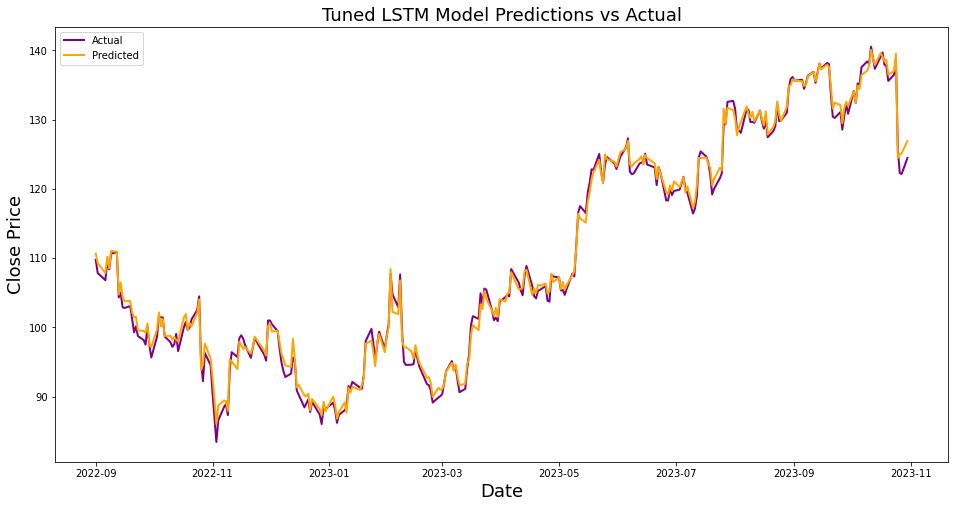

In [35]:
# Plot the predictions of LSTM model without Hyperparameter tuning
plt.figure(figsize=(16,8))
plt.title('Tuned LSTM Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='purple', label='Actual')
plt.plot(df1.index[-len(y_test):], pred_best_lstm_inv, linewidth=2, color='orange', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(loc='best')
plt.show()

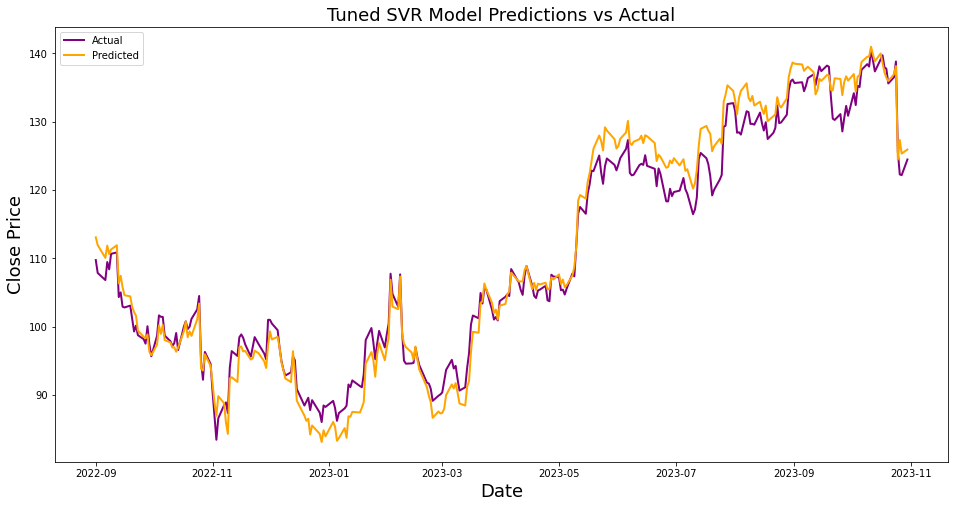

In [36]:
# Plot the predictions for SVR model without Hyperparameter Tuning
plt.figure(figsize=(16,8))
plt.title('Tuned SVR Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='purple', label='Actual')
plt.plot(df1.index[-len(y_test):], pred_best_svr_inv, linewidth=2, color='orange', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(loc='best')
plt.show()

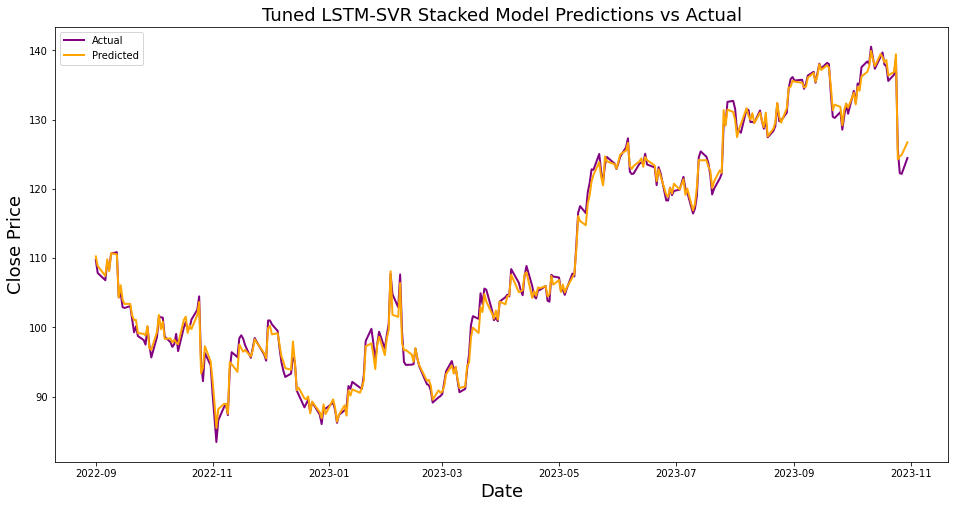

In [37]:
# Plot the predictions for Stacked model without Hyperparameter Tuning
plt.figure(figsize=(16,8))
plt.title('Tuned LSTM-SVR Stacked Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='purple', label='Actual')
plt.plot(df1.index[-len(y_test):], final_tuned_pred_inv, linewidth=2, color='orange', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(loc='best')
plt.show()

In [38]:
# Build a dataframe with actual and predicted prices
df_pred_1 = pd.DataFrame({'Date': df1.index[-len(y_test):],'Actual': y_test_inv.flatten(), 'LSTM-Tuned': pred_best_lstm_inv.flatten(), 'SVR-Tuned': pred_best_svr_inv.flatten(), 'Stacked-Tuned': final_tuned_pred_inv.flatten()})
df_pred_1.tail(20)

,Date,Actual,LSTM-Tuned,SVR-Tuned,Stacked-Tuned
272,2023-10-03,132.429993,132.431839,134.404998,132.214550
273,2023-10-04,135.240005,134.929749,136.595297,134.738554
274,2023-10-05,135.070007,134.399887,136.788777,134.187471
275,2023-10-06,137.580002,136.431778,138.721514,136.236991
276,2023-10-09,138.419998,137.095291,139.511125,136.902487
277,2023-10-10,138.059998,137.798492,139.528211,137.627326
278,2023-10-11,140.550003,140.082520,140.977515,139.948416
279,2023-10-12,138.970001,138.854523,139.817446,138.709564
280,2023-10-13,137.360001,137.898407,138.847797,137.746591
281,2023-10-16,139.100006,139.609344,139.980253,139.484166


In [39]:
# Take the last day of data for predictions
last_features = X_scaled[-1:]

predicted_prices_best_lstm = []

# Predicting stock prices for the next 2 days
for _ in range(2):
    # Prepare the last features for LSTM input shape
    last_features_lstm = last_features.reshape(1, 1, X_train_lstm.shape[2])
    
    # Predicting the next day stock price using the last feature data
    predicted_price = best_lstm_model.predict(last_features_lstm)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped = predicted_price.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price = target_scaler.inverse_transform(predicted_price_reshaped)[0][0]
    predicted_prices_best_lstm.append(inverse_transformed_price)

    # Computing new features based on the predicted price
    new_features = np.array([
        last_features[0, 1],  # 'Open' value for the next day (shifted from 'High' of the current day)
        last_features[0, 2],  # 'High' value for the next day (shifted from 'Low' of the current day)
        predicted_price_reshaped[0, 0], # 'Low' value (using the predicted closing price as an approximation)
        (predicted_price_reshaped[0, 0] - last_features[0, 3]) / last_features[0, 3],  # Return for the predicted day
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped[0, 0])),  # 5-day moving average
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped[0, 0])),  # 10-day moving average
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped[0, 0]))    # 10-day moving standard deviation
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features

print("\nPredicted Closing Prices for the Next 2 Days (Best LSTM Model):")
for i, price in enumerate(predicted_prices_best_lstm):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step

Predicted Closing Prices for the Next 2 Days (Best LSTM Model):
Day 1:126.923
Day 2:123.961


In [40]:
last_features = X_scaled[-1:]

# Predict using the svr model
predicted_prices_best_svr = []

last_features_svr = last_features.copy()

for _ in range(2):
    # Predicting the next day stock price using the last feature data
    predicted_price_svr = best_svr_model.predict(last_features_svr)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_svr = predicted_price_svr.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price_svr = target_scaler.inverse_transform(predicted_price_reshaped_svr)[0][0]
    predicted_prices_best_svr.append(inverse_transformed_price_svr)

    # Computing new features based on the predicted price
    # Here we reuse the logic for LSTM for simplicity. Depending on the scenario, the exact methodology might change.
    new_features_svr = np.array([
        last_features_svr[0, 1], 
        last_features_svr[0, 2], 
        predicted_price_reshaped_svr[0, 0], 
        (predicted_price_reshaped_svr[0, 0] - last_features_svr[0, 3]) / last_features_svr[0, 3],
        np.mean(np.append(last_features_svr[0, 4:6], predicted_price_reshaped_svr[0, 0])),
        np.mean(np.append(last_features_svr[0, 5:], predicted_price_reshaped_svr[0, 0])),
        np.std(np.append(last_features_svr[0, 6:], predicted_price_reshaped_svr[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features_svr = new_features_svr

print("\nPredicted Closing Prices for the Next 2 Days (Best SVR Model):")
for i, price in enumerate(predicted_prices_best_svr):
    print(f"Day {i+1}:" "{:.3f}".format(price))


Predicted Closing Prices for the Next 2 Days (Best SVR Model):
Day 1:125.925
Day 2:123.521


In [41]:
last_features = X_scaled[-1:]

# Predict using the stacked model
predicted_prices_best_stacked = []

last_features_stacked = last_features.copy()

for _ in range(2):
    # Reshape the last features for LSTM input shape
    last_features_lstm = last_features.reshape(1, 1, X_train_lstm.shape[2])

    # Predict using the LSTM model & SVR model
    lstm_pred_for_stacking = best_lstm_model.predict(last_features_lstm).flatten()
    svr_pred_for_stacking = best_svr_model.predict(last_features_stacked).flatten()

    # Stack the predictions together
    stacked_pred = np.column_stack((lstm_pred_for_stacking, svr_pred_for_stacking))

    # Predict using the final regressor
    predicted_stacked = final_regressor.predict(stacked_pred)

    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_stacked = predicted_stacked.reshape(-1, 1)

    # Saving the predicted price after inverse transformation
    inverse_transformed_price_stacked = target_scaler.inverse_transform(predicted_price_reshaped_stacked)[0][0]
    predicted_prices_best_stacked.append(inverse_transformed_price_stacked)

    # Computing new features based on the predicted price
    # Here we reuse the logic for LSTM for simplicity. Depending on the scenario, the exact methodology might change.
    new_features_stacked = np.array([
        last_features_stacked[0, 1], 
        last_features_stacked[0, 2], 
        predicted_price_reshaped_stacked[0, 0], 
        (predicted_price_reshaped_stacked[0, 0] - last_features_stacked[0, 3]) / last_features_stacked[0, 3],
        np.mean(np.append(last_features_stacked[0, 4:6], predicted_price_reshaped_stacked[0, 0])),
        np.mean(np.append(last_features_stacked[0, 5:], predicted_price_reshaped_stacked[0, 0])),
        np.std(np.append(last_features_stacked[0, 6:], predicted_price_reshaped_stacked[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features_stacked = new_features_stacked

print("\nPredicted Closing Prices for the Next 2 Days (Best Stacked Model):")
for i, price in enumerate(predicted_prices_best_stacked):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step

Predicted Closing Prices for the Next 2 Days (Best Stacked Model):
Day 1:127.493
Day 2:127.561
